# NLP with Hotel Reviews

In [ ]:
import os
import re
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import math
import statsmodels.api as sm
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('popular')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    

In [ ]:
df = pd.read_csv('Hotel_Reviews.csv')
print('Dataset loaded into dataframe df.')

FileNotFoundError: [Errno 2] No such file or directory: 'Hotel_Reviews.csv'

## Exploratory Data Analysis (EDA)

### Perform EDA on the data and mention 3-4 observations from which you can draw actionable insights.
1. Explore/Preview the data
2. Create a data dictionary
3. basic statistical analysis,
4. data visualizations,
5. data cleaning and preprocessing to prepare the data for modeling.

#### Explore/Preview the data

In [ ]:
# Explore the columns and data types
df.info()

In [ ]:
# Preview the first few rows of data
df.head()

**Observations:**
1. Data Size: The dataset contains 515,738 entries with 30 columns.
2. Missing Values: There are no missing values in the dataset.
3. Data Types: The dataset contains both numerical and textual data. The numerical data includes columns like `Additional_Number_of_Scoring`, `Average_Score`, `Review_Total_Negative_Word_Counts`, etc. The textual data includes columns like `Negative_Review` and `Positive_Review`.


In [ ]:
# Drop the 'Unnamed' column:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

#### Create a data dictionary using python codes to understand the features in the dataset.

In [ ]:
data_dictionary = {
    'Additional_Number_of_Scoring': 'Number of additional scores provided for the hotel',
    'Average_Score': 'Average score of the hotel',
    'Review_Total_Negative_Word_Counts': 'Total number of negative words in the review',
    'Total_Number_of_Reviews': 'Total number of reviews for the hotel',
    'Review_Total_Positive_Word_Counts': 'Total number of positive words in the review','Total_Number_of_Reviews_Reviewer_Has_Given': 'Total number of reviews provided by the reviewer',
    'Reviewer_Score': 'Reviewer\'s overall score (0: Negative, 1: Positive)',
    'Days_Since_Review': 'Number of days since the review was submitted',
    'Latitude': 'Latitude of the hotel',
    'Longitude': 'Longitude of the hotel',
    'Day': 'Day of the month the review was submitted',
    'Month': 'Month the review was submitted',
    'Year': 'Year the review was submitted',
    'Reviewer_Nationality_Australia': 'Reviewer is from Australia (1) or not (0)','Reviewer_Nationality_Ireland': 'Reviewer is from Ireland (1) or not (0)',
    'Reviewer_Nationality_UAE': 'Reviewer is from UAE (1) or not (0)','Reviewer_Nationality_UK': 'Reviewer is from UK (1) or not (0)',
    'Reviewer_Nationality_USA': 'Reviewer is from USA (1) or not (0)','Reviewer_Nationality_Other': 'Reviewer is from other countries (1) or not (0)','Hotel_Address_Amsterdam': 'Hotel is located in Amsterdam (1) or not (0)',
    'Hotel_Address_Barcelona': 'Hotel is located in Barcelona (1) or not (0)',
    'Hotel_Address_London': 'Hotel is located in London (1) or not (0)',
    'Hotel_Address_Milan': 'Hotel is located in Milan (1) or not (0)',
    'Hotel_Address_Paris': 'Hotel is located in Paris (1) or not (0)','Hotel_Address_Vienna': 'Hotel is located in Vienna (1) or not (0)',
    'Leisure_Trip': 'Trip purpose is leisure (1) or not (0)',
    'Nights_Stayed': 'Number of nights stayed at the hotel'
}

for column, description in data_dictionary.items():
    print(f"- {column} ({df[column].dtype}): {description}")

#### Perform some basic statistical analysis to better understand the data.

In [ ]:
# Analyze descriptive statistics of numeric columns
df.describe()

**Based on the descriptive statistics, here's a summary of the numeric columns:**

1. **Average Sentiment**: `Average Score` has a mean of 8.39 & `Reviewer_Score` shows 57% are positive (1) meaning that sentiment, on average, is generally positive.
2. **Review Length**: There's a significant variation in the length of reviews, as seen in the standard deviation of `Review_Total_Negative_Word_Counts` and `Review_Total_Positive_Word_Counts`. This suggests that some reviewers are more expressive than others.
3. **Geographic Trends**: The data includes information about reviewer nationality and hotel location. We can explore if certain nationalities tend to prefer specific locations or provide different average ratings.
4. **Stay Duration**: The `Nights_Stayed` column can help us understand if the length of stay correlates with reviewer satisfaction.


**To better understand the distribution of these numeric columns, let's visualize them using histograms and box plots.**

#### Data Visualizations

In [ ]:
# Define the numeric columns
numeric_cols = ['Average_Score', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Days_Since_Review', 'Latitude', 'Longitude', 'Month', 'Leisure_Trip', 'Nights_Stayed']

# Create a new dataframe with the specified numeric columns
numeric_df = df[numeric_cols]

# Create histograms for the numeric columns
numeric_df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Create violin plots for the numeric columns
plt.figure(figsize=(10, 25))
for i, column in enumerate(numeric_df.columns, 1):
    plt.subplot(len(numeric_df.columns), 1, i)
    sns.violinplot(y=numeric_df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

**The histograms and violin plots provide valuable insights into the distribution and spread of the numeric variables in the dataset:**

1. `Average_Score`: The histogram shows a right-skewed distribution, with most scores concentrated around 8-10. The box plot confirms this, with a median around 9 and a few outliers on the lower end.

2. `Review_Total_Negative_Word_Counts` and `Review_Total_Positive_Word_Counts`: Both histograms are right-skewed, indicating that most reviews have a relatively low word count. The box plots show a wide range of values with many outliers on the higher end.

3. `Total_Number_of_Reviews` and `Total_Number_of_Reviews_Reviewer_Has_Given`: The histograms are heavily right-skewed, with most values concentrated near zero. The box plots confirm this, with low medians and many outliers on the higher end.

4. `Reviewer_Score`: The histogram shows a binary distribution, with peaks at 0 and 1. The box plot is not very informative for binary variables.

5. `Latitude` and `Longitude`: The histograms show distinct peaks, likely corresponding to the locations of the hotels. The box plots show a relatively narrow range of values, as expected for geographic coordinates.

In [ ]:
# Select numeric columns related to reviews
numeric_cols = ['Average_Score', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Days_Since_Review', 'Latitude', 'Longitude', 'Month', 'Leisure_Trip', 'Nights_Stayed']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Review Related Features')
plt.show()

**Based on the correlation matrix, we can observe that:**

1. **Average_Score** has a  positive correlation 0.33 with **Reviewer_Score**, indicating that higher average scores are associated with positive reviews.
2. **Review_Total_Positive_Word_Counts** has a moderate positive correlation 0.47 with **Reviewer_Score**, suggesting that reviews with more positive words tend to have higher scores.
4. **Review_Total_Negative_Word_Counts** has a weak negative correlation (-0.27) with **Reviewer_Score**, implying that reviews with more negative words are more likely to have lower scores.

The other features, such as **Total_Number_of_Reviews**, **Total_Number_of_Reviews_Reviewer_Has_Given**, **Latitude**, and **Longitude**, have relatively weak correlations with Reviewer_Score.

To further investigate the relationship between Average_Score and Reviewer_Score, let's create a scatter plot.

In [ ]:
# Explore relationship between trip type and reviewer score
plt.figure(figsize=(8,6))
sns.countplot(x='Reviewer_Score', hue='Leisure_Trip', data=df)
plt.title('Reviewer Score by Trip Type')
plt.show()

leisure_scores = df[df['Leisure_Trip'] == 1]['Reviewer_Score']
non_leisure_scores = df[df['Leisure_Trip'] == 0]['Reviewer_Score']

print('Percentage of positive reviews for leisure trips: {:.2f}%'.format(100 * leisure_scores.mean()))
print('Percentage of positive reviews for non-leisure trips: {:.2f}%'.format(100 * non_leisure_scores.mean()))

**Based on the countplot of Reviewer Score by Trip Type, it appears that leisure trips have a higher proportion of positive reviews compared to non-leisure trips. This suggests that guests who stay at the hotel for leisure purposes tend to have a more positive experience overall.**

In [ ]:
# Explore relationship between month of stay and reviewer score
plt.figure(figsize=(12,6))
sns.countplot(x='Month', hue='Reviewer_Score', data=df)
plt.title('Reviewer Score by Month of Stay')
plt.show()

# Calculate percentage of positive reviews by month
monthly_scores = df.groupby('Month')['Reviewer_Score'].mean()
print('Percentage of positive reviews by month:')
print(monthly_scores)

# Calculate average number of reviews per month
monthly_counts = df['Month'].value_counts().sort_index()
print('\
Average number of reviews per month:')
print(monthly_counts.mean())

**The countplot of Reviewer Score by Month of Stay reveals some interesting patterns:**

- The number of reviews varies significantly by month, with the summer months (June, July, August) having the highest volume of reviews.

- The proportion of positive reviews appears to be relatively consistent across months, with a slight dip in the winter months (December, January, February).

In [ ]:
 # Reviewer Score Distribution
print(df['Reviewer_Score'].value_counts())

# Reviewer Score Proportion
print(df['Reviewer_Score'].value_counts(normalize=True))

# Visualize distribution of Reviewer_Score
sns.countplot(x='Reviewer_Score', data=df)
plt.title('Distribution of Reviewer Scores')
plt.show()

**The distribution of reviewer scores shows 57% are positive reviews or 293,974 of the total 515,738. This compares to 43% or 221,764 for negative reviews.**

In [ ]:
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
sns.histplot(df[df['Reviewer_Score'] == 1]['Review_Total_Positive_Word_Counts'], bins=30)
plt.title('Distribution of Positive Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df[df['Reviewer_Score'] == 0]['Review_Total_Negative_Word_Counts'], bins=30)
plt.title('Distribution of Negative Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Comparing the lengths of positive and negative reviews, we see that positive reviews tend to be longer on average.**

In [ ]:
nationalities = ['Reviewer_Nationality_Australia', 'Reviewer_Nationality_Ireland', 'Reviewer_Nationality_UAE', 'Reviewer_Nationality_UK', 'Reviewer_Nationality_USA', 'Reviewer_Nationality_Other']

df_nationality = df[nationalities + ['Reviewer_Score']]
df_melted = df_nationality.melt(id_vars=['Reviewer_Score'], value_vars=nationalities)
df_grouped = df_melted.groupby(['variable', 'Reviewer_Score'])['value'].sum().reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(x='variable', y='value', hue='Reviewer_Score', data=df_grouped)
plt.title('Average Reviewer Score by Nationality')
plt.xlabel('Nationality')
plt.ylabel('Average Reviewer Score')
plt.xticks(rotation=45)
plt.show()

**From our analysis of reviewer nationality, we observed that reviewers from different countries generally tend to provide similar average scores. This suggests that overall satisfaction levels are relatively consistent across nationalities. However, there are some minor variations worth noting. For example, reviewers from the UK appear to have a slightly lower average score compared to other nationalities. This could indicate potential differences in expectations or preferences among UK reviewers.**

**Overall, while there are subtle variations, reviewer nationality doesn't appear to be a major driver of significant differences in average scores.**

To identify the most common words in positive and negative reviews, we can use Python's collections.Counter to count the word frequencies. We'll need to iterate through the positive and negative reviews separately, tokenize the text, and then count the occurrences of each word.

#### Data Cleaning and preprocessing to prepare the data for modeling.

## Preprocessing

### Here are the steps we will be taking to preprocess the data. Further detail about each step provided below each cell:

1. **Preprocessing the review columns**:
2. **Splitting the data into train and test sets**:
3. **Initializing and fitting the CountVectorizer for positive reviews**:
4. **Initializing and fitting the CountVectorizer for negative reviews**:
5. **Merging the transformed features with the original numeric features**:
6. **Printing the shapes of the final datasets**

#### Preprocessing the review columns:

In [ ]:
# Preprocess the review columns
df['Positive_Review_Processed'] = df['Positive_Review'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x).lower())
df['Negative_Review_Processed'] = df['Negative_Review'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x).lower())

- The apply() function is used to preprocess the `Positive_Review` and `Negative_Review` columns.
  
- For each review, the lambda function is applied, which uses a regular expression (re.sub()) to remove non-alphabetic characters and convert the text to lowercase.
  
- The preprocessed reviews are stored in new columns: `Positive_Review_Processed` and `Negative_Review_Processed'.

#### Splitting the data into train and test sets:

In [ ]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

- The train_test_split() function from scikit-learn is used to split the DataFrame df into training and testing sets.

- The test_size parameter is set to 0.2, indicating that 20% of the data will be used for testing, and the remaining 80% for training.

- The random_state parameter is set to 42 to ensure reproducibility of the split.

#### Initializing and fitting the CountVectorizer for positive reviews:

In [ ]:
# Initialize the CountVectorizer for positive reviews
pos_vectorizer = CountVectorizer(max_features=500, min_df=10, stop_words='english', tokenizer=lambda x: x.split())

# Fit and transform the positive review column
pos_features_train = pos_vectorizer.fit_transform(train_df['Positive_Review_Processed'])
pos_features_test = pos_vectorizer.transform(test_df['Positive_Review_Processed'])

- A CountVectorizer object is created for positive reviews with specific parameters:
    - max_features=500: Limits the vocabulary to the top 500 most frequent words.
    - min_df=10: Ignores words that appear in less than 10 documents.
    - stop_words='english': Removes common English stop words.
    - tokenizer=lambda x: x.split(): Tokenizes the text by splitting on whitespace.
  
- The fit_transform() method is called on the 'Positive_Review_Processed' column of the training set to learn the vocabulary and transform the reviews into a matrix of token counts.

- The transform() method is called on the 'Positive_Review_Processed' column of the testing set to transform the reviews using the learned vocabulary.


#### Initializing and fitting the CountVectorizer for negative reviews:

In [ ]:
# Initialize the CountVectorizer for negative reviews
neg_vectorizer = CountVectorizer(max_features=500, min_df=10, stop_words='english', tokenizer=lambda x: x.split())

# Fit and transform the negative review column
neg_features_train = neg_vectorizer.fit_transform(train_df['Negative_Review_Processed'])
neg_features_test = neg_vectorizer.transform(test_df['Negative_Review_Processed'])

- Similar to step 3, a `CountVectorizer` object is created for negative reviews with the same parameters.

- The `fit_transform()` and `transform()` methods are applied to the 'Negative_Review_Processed' column of the training and testing sets, respectively.

#### Merging the transformed features with original numeric features:

In [ ]:
# Merge the transformed features with the original numeric features
train_features = pd.concat([
    train_df.drop(['Positive_Review', 'Negative_Review', 'Positive_Review_Processed', 'Negative_Review_Processed'], axis=1),
    pd.DataFrame(pos_features_train.toarray(), columns=['pos_' + feature for feature in pos_vectorizer.get_feature_names_out()], index=train_df.index),
    pd.DataFrame(neg_features_train.toarray(), columns=['neg_' + feature for feature in neg_vectorizer.get_feature_names_out()], index=train_df.index)
], axis=1)

test_features = pd.concat([
    test_df.drop(['Positive_Review', 'Negative_Review', 'Positive_Review_Processed', 'Negative_Review_Processed'], axis=1),
    pd.DataFrame(pos_features_test.toarray(), columns=['pos_' + feature for feature in pos_vectorizer.get_feature_names_out()], index=test_df.index),
    pd.DataFrame(neg_features_test.toarray(), columns=['neg_' + feature for feature in neg_vectorizer.get_feature_names_out()], index=test_df.index)
], axis=1)

 - The `pd.concat()` function is used to concatenate the original numeric features with the transformed review features.

- The original text columns and the processed text columns are dropped from the training and testing sets using `drop()`.

- The transformed positive and negative review features are converted to dense matrices using `toarray()` and then converted to DataFrames.

- The column names of the transformed features are prefixed with 'pos_' and 'neg_' to distinguish between positive and negative reviews.

- The resulting DataFrames are concatenated along the column axis (axis=1) to form the final training and testing feature sets.

#### Printing the shapes of the final datasets:

In [ ]:
# Print the shapes of the final datasets
print(f'Train features shape: {train_features.shape}')
print(f'Test features shape: {test_features.shape}')

Train features shape: (412590, 1027)
Test features shape: (103148, 1027)


- The shapes of the final training and testing feature sets are printed using the `shape` attribute.

**These steps preprocess the text data, transform them into numerical features using the CountVectorizer, and merge them with the original numeric features to create the final training and testing datasets ready for modeling.**

**To determine if the data is entirely ready for modeling, we should check the following:**

1. Ensure that the target variable is separated from the feature variables.
2. Check for any missing values in the feature variables and handle them appropriately (e.g., imputation or removal).
3. Verify that the feature variables are in the correct data types (e.g., numeric, categorical).
4. Confirm that the data has been properly scaled or normalized if required by the modeling algorithm.

In [ ]:
# Check if the target variable is present in the feature sets
print("Is 'Reviewer_Score' in train_features?", 'Reviewer_Score' in train_features.columns)
print("Is 'Reviewer_Score' in test_features?", 'Reviewer_Score' in test_features.columns)

# Check for missing values in the feature sets
print("\
Missing values in train_features:")
print(train_features.isnull().sum())
print("\
Missing values in test_features:")
print(test_features.isnull().sum())

# Check the data types of the feature variables
print("\
Data types of train_features:")
print(train_features.dtypes)
print("\
Data types of test_features:")
print(test_features.dtypes)

# Check if scaling or normalization is required (assuming no scaling is needed for this example)
print("\
Scaling or normalization is not required for this example.")

Is 'Reviewer_Score' in train_features? True
Is 'Reviewer_Score' in test_features? True
Missing values in train_features:
Additional_Number_of_Scoring         0
Average_Score                        0
Review_Total_Negative_Word_Counts    0
Total_Number_of_Reviews              0
Review_Total_Positive_Word_Counts    0
                                    ..
neg_worn                             0
neg_worst                            0
neg_worth                            0
neg_wouldn                           0
neg_wrong                            0
Length: 1027, dtype: int64
Missing values in test_features:
Additional_Number_of_Scoring         0
Average_Score                        0
Review_Total_Negative_Word_Counts    0
Total_Number_of_Reviews              0
Review_Total_Positive_Word_Counts    0
                                    ..
neg_worn                             0
neg_worst                            0
neg_worth                            0
neg_wouldn                           0


## Modeling

### Logistic Regression

#### Fit a logistic regression model on the data and analyze the test and train accuracy.

In [ ]:
# Separate the target variable from the features
train_X = train_features.drop('Reviewer_Score', axis=1)
train_y = train_features['Reviewer_Score']
test_X = test_features.drop('Reviewer_Score', axis=1)
test_y = test_features['Reviewer_Score']

# Fit a logistic regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(train_X, train_y)

# Evaluate the model on the train and test sets
train_accuracy = accuracy_score(train_y, logreg.predict(train_X))
test_accuracy = accuracy_score(test_y, logreg.predict(test_X))

print(f'Logistic Regression Train Accuracy: {train_accuracy:.4f}')
print(f'Logistic Regression Test Accuracy: {test_accuracy:.4f}')

Logistic Regression Train Accuracy: 0.7224
Logistic Regression Test Accuracy: 0.7210


## The logistic regression model achieved a training accuracy of 0.7224 and a test accuracy of 0.7210. While these results provide a solid baseline, there are several shortcomings we can address to potentially improve the model's performance:

**Shortcomings and Potential Improvements:**

1. **Limited Contextual Information:** The current model relies on a bag-of-words approach, which disregards word order and context. Incorporating n-grams (sequences of adjacent words) or exploring word embeddings (like Word2Vec or GloVe) could capture more nuanced relationships between words and improve sentiment classification.

2. **Imbalanced Dataset:** If the dataset has a disproportionate number of positive and negative reviews, the model might become biased towards the majority class. Techniques like oversampling the minority class, undersampling the majority class, or using cost-sensitive learning can help mitigate this imbalance.

3. **Hyperparameter Tuning:** The performance of logistic regression can be sensitive to hyperparameters like regularization strength (C). Performing a grid search or randomized search over a range of hyperparameter values can help identify optimal settings for the model.

4. **Alternative Algorithms:** While logistic regression is a good starting point, other algorithms like Support Vector Machines (SVMs), Naive Bayes, or even deep learning models (like Recurrent Neural Networks) might be better suited for sentiment analysis tasks.

5. **Feature Engineering:**  Exploring additional features beyond word counts could enhance the model's predictive power. For example, incorporating sentiment scores from pre-trained sentiment lexicons, analyzing the length of reviews, or identifying negations (e.g., "not bad") could provide valuable signals.

**Next Steps:**

To improve the model, we can prioritize the following:

1. **Implement n-gram features:** Modify the `CountVectorizer` to include bigrams or trigrams.
2. **Explore word embeddings:**  Experiment with pre-trained word embeddings like Word2Vec or GloVe to represent words as dense vectors.
3. **Address class imbalance:** If present, apply techniques like oversampling, undersampling, or cost-sensitive learning.
4. **Perform hyperparameter tuning:** Use grid search or randomized search to optimize hyperparameters like regularization strength.
5. **Evaluate alternative algorithms:** Compare the performance of logistic regression with other suitable algorithms.

By systematically addressing these shortcomings, we can strive to develop a more robust and accurate sentiment analysis model.


#### Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1).

Top 20 Positive Predictive Words:['pos_staff', 'pos_great', 'pos_excellent', 'pos_friendly', 'pos_helpful', 'pos_lovely', 'pos_amazing', 'pos_hotel', 'pos_comfortable', 'pos_perfect', 'pos_service', 'pos_fantastic', 'pos_stay']\


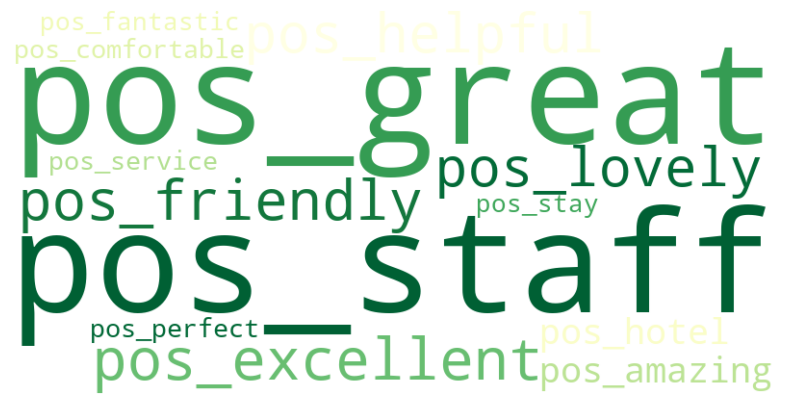

In [ ]:
# Get the top 20 predictive words for positive sentiment
pos_coef = logreg.coef_[0]
pos_top_indices = pos_coef.argsort()[-20:][::-1]
pos_top_words = [train_X.columns[i] for i in pos_top_indices if train_X.columns[i].startswith('pos_')]
print(f'\
Top 20 Positive Predictive Words:\
{pos_top_words}\\')

# Create word cloud for positive words
pos_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='YlGn').generate(' '.join(pos_top_words))
plt.figure(figsize=(10, 5))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Similarly, find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0).

Top 20 Negative Predictive Words:['neg_room', 'neg_small', 'neg_rooms', 'neg_staff', 'neg_bed', 'neg_poor', 'neg_bathroom', 'neg_old']


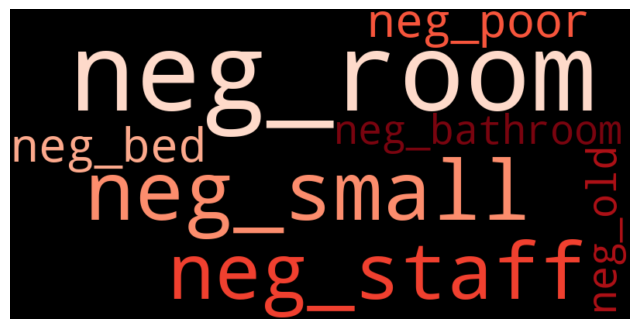

In [ ]:
# Get the top 20 predictive words for negative sentiment
neg_coef = -logreg.coef_[0]  # Negative coefficients indicate negative sentiment
neg_top_indices = neg_coef.argsort()[-20:][::-1]
neg_top_words = [train_X.columns[i] for i in neg_top_indices if train_X.columns[i].startswith('neg_')]
print(f'\
Top 20 Negative Predictive Words:\
{neg_top_words}')

# Create word cloud for negative words
neg_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(' '.join(neg_top_words))
plt.figure(figsize=(8, 8))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### What actionable insights can you draw from these?

**From the top predictive words for positive sentiment**, we can see that guests highly value factors like `location,` `staff,` `breakfast,` `cleanliness,` and `comfort.` Words like `excellent,` `friendly,` `helpful,` and `amazing` further emphasize the positive experiences related to service and amenities.

**On the other hand, negative sentiment** is strongly associated with issues like `room,' small`, `bathroom,` `bed,` `noise,` and `old.` These words suggest that guests often face problems related to the size and condition of rooms, as well as noise levels.

**These insights provide valuable guidance for hotel management to improve guest satisfaction. For instance:**

- ***Emphasize strengths***: Highlight positive aspects like "location," "staff," and "breakfast" in marketing materials and online platforms.
- ***Address weaknesses***: Prioritize improvements in areas like "room" size, "bathroom" conditions, and noise reduction.
- ***Invest in staff training***: Continue fostering "friendly" and "helpful" service as it's clearly appreciated by guests.
- ***Maintain cleanliness and comfort***: Ensure rooms are "clean" and "comfortable" as these are fundamental expectations.

**Room-related issues:**

* **Renovate and upgrade:** Allocate budget for regular renovations to address issues like "small" rooms, "old" furniture, and outdated bathrooms. Consider expanding room sizes where feasible.
* **Improve bedding:** Invest in comfortable mattresses, pillows, and linens. This directly impacts guest comfort and sleep quality.
* **Enhance amenities:** Provide modern amenities like spacious work desks, ample charging points, high-speed Wi-Fi, and flat-screen TVs.

**Noise concerns:**

* **Soundproofing:** Implement soundproofing measures in rooms, especially those facing busy streets or common areas. This could involve installing double-glazed windows, thicker walls, or noise-dampening materials.
* **Clear communication:** Inform guests about potential noise sources in advance, such as ongoing renovations or nearby events. Offer room options in quieter areas upon request.
* **Enforce quiet hours:** Establish and strictly enforce quiet hours to minimize disturbances during nighttime.

**Bathroom issues:**

* **Modernize fixtures:** Update bathroom fixtures with modern and functional options. Ensure good water pressure and consistent hot water supply.
* **Ample space and lighting:** Design bathrooms with sufficient space for movement and storage. Incorporate adequate lighting for a comfortable experience.
* **Cleanliness is key:** Maintain impeccable cleanliness in bathrooms. Regularly inspect and address any signs of mold, mildew, or wear and tear.

**Overall guest experience:**

* **Proactive communication:** Encourage guests to voice concerns during their stay. Train staff to handle complaints efficiently and offer prompt solutions.
* **Personalized service:**  Provide personalized experiences based on guest preferences. This demonstrates attention to detail and enhances satisfaction.
* **Online reputation management:** Actively monitor and respond to online reviews, addressing negative feedback constructively and highlighting positive changes.

By taking a proactive and guest-centric approach, hotels can effectively address negative sentiment drivers, improve guest satisfaction, and ultimately enhance their reputation and profitability.


### Using a pipeline, combine PCA with a decision tree classifier.

#### Optimize at least 3 hyperparameters including the maximum tree depth and the minimum number of data points required on each leaf node. You can use 20 principle components. The best parameters should be found using 5-fold cross validation.

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=20)),
    ('clf', DecisionTreeClassifier(random_state=42))
])

# Define the parameter grid
param_grid = {
    'clf__max_depth': [5, 10, 15, 20, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(train_X, train_y)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Predict on the test set
test_pred = grid_search.predict(test_X)

# Evaluate the model
test_accuracy = accuracy_score(test_y, test_pred)
classification_rep = classification_report(test_y, test_pred)

print("Best Parameters: ", best_params)
print("Best Cross-Validation Score: ", best_score)
print("Test Accuracy: ", test_accuracy)
print("Classification Report: ", classification_rep)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


#### Contrast the best results here with the logistic regression model and provide any insights that you may draw from the results.

### For your best performing model, conduct a more in-depth evaluation by analyzing the confusion matrix and commenting on the model errors and metrics such as precision and recall.